In [6]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

In [7]:
def DegToTurns(deg):
    ratio = 45/1000 # degrees / turns
    return deg / ratio

def TurnsToDeg(turns):
    ratio = 45/1000 # degrees / turns
    return turns * ratio

In [8]:
def WriteFile(fileName, data):
 
    data = np.transpose(data)
    
    with open(fileName, "w") as f:
        np.savetxt(fileName, data)

def LoadFile(path):
    data = np.array(np.loadtxt(path))
    return data

In [9]:
def ExternalToInternalAngle(external, n=1.53, A=45):
    # input external angle in degrees, refractive index, prism angle
    # returns internal angle in degrees
    radPerDeg = np.pi / 180
    
    external *= radPerDeg
    A *= radPerDeg
    
    return (np.arcsin(np.sin(external - A) / n) + A) * 180 / np.pi

In [10]:
def ConvertNToDegrees(data, offset, mode="external"):
    # returns the same set of data with the x column changing to degrees
    NValues = data[:,0]
    degrees = list()
    
    degreesPerN = 45/1000
    
    i=0
    for N in NValues:
        
        if mode == "internal":
            degrees.append(ExternalToInternalAngle(N * degreesPerN + offset))
        if mode == "external":
            degrees.append(N * degreesPerN + offset)
            
        i+=1
        
    data[:,0] = degrees
    
    return data

In [11]:
def NormaliseData(data):
    maxVal = 0
    for el in data[:,1]: # Loop through all data elements
        if el > maxVal:
            maxVal = el

    data[:,1] = [el / maxVal for el in data[:,1]]
    return data

In [12]:
def PlotFile(path, angleMode = "external", offset=30.5, normalise=True, errors=True, label="", showPlot=True, returnData=False):
    if type(path) == str: data = LoadFile(path)
    if type(path) == np.ndarray : data = path

    if normalise:
        data = NormaliseData(data)
        if showPlot: plt.ylabel("Normalised Intensity")
    else:
        if showPlot: plt.ylabel("Intensity")

    if angleMode == "external":    
        data = ConvertNToDegrees(data, offset, mode="external")
        
    if angleMode == "internal":
        data = ConvertNToDegrees(data, offset, mode="internal")

    if showPlot:  
        plt.xlabel(f"{angleMode.upper()} Angle (Degrees)")

        plt.plot(data[:,0], data[:,1], label=label, zorder=1)

        if errors: plt.errorbar(data[:,0], data[:,1], yerr=data[:,2], fmt="", zorder=0)
        
        plt.grid()
        if label != "":
            plt.legend()

    if returnData:       
        return data

In [13]:
def PlotAverageFiles(pathList, angleMode="external", offset=0, normalise=True, errors=True):
    
    dataList = [np.array(np.loadtxt(file)) for file in pathList]
    
    dataAvg = np.zeros(np.shape(dataList[0]))
    dataAvg[:,0] = dataList[0][:,0]

    voltagesOfEachData=list()
    for data in dataList:
        
        voltagesOfEachData.append(data[:,1])

        k=0
        stds = list()
        voltagesOfEachData = np.array(voltagesOfEachData)
        while k < len(voltagesOfEachData[:,0]):
            V = list()
            for voltageList in voltagesOfEachData:
                V.append(voltageList[k])
            dataAvg[:,1][k] = np.mean(V)
            stds.append(np.std(V))
            k+=1


    # Weighting uncertainties based on distance from mean value
    for data in dataList:
        i=0
        weights=list()
        for voltage in data[:,1]:
            w = (1 - abs(dataAvg[:,1][i] - voltage))
            if w < 0 : w = 0

            weights.append(w*voltage)
            i+=1
        
        j=0
        for uncertainty in data[:,2]:
            dataAvg[:,2][j] += data[:,2][j]*weights[j]
            j+=1

        print(stds)
        dataAvg[:,2] = dataAvg[:,2]*dataAvg[:,1] / (len(dataList) * stds[j])
    
    PlotFile(dataAvg, angleMode=angleMode, offset=offset, normalise=normalise, errors=errors)

## Red -> 633 nm

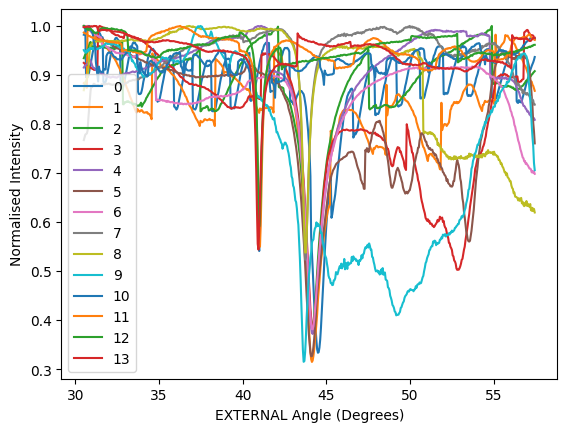

In [91]:
fileListRed = glob("10nm/red/*.txt") + glob("13nm/red/*.txt") + glob("15nm/red/*.txt")

i=0
for file in [str(el) for el in np.sort(fileListRed)]:
    PlotFile(file, errors=False, label=i)
    i+=1

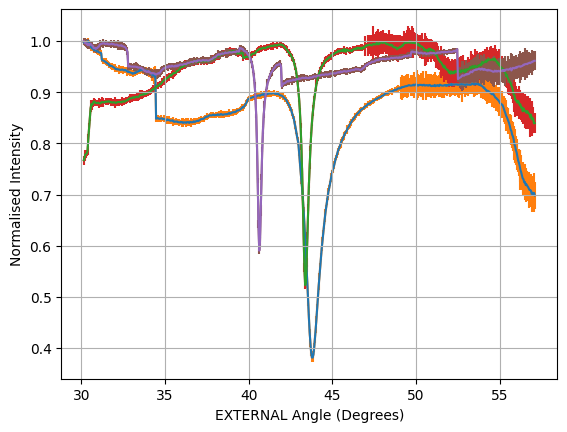

In [75]:
PlotFile("10nm/red/red07.txt", offset=30.15)
PlotFile("13nm/red/red01.txt",offset=30.15)
PlotFile("15nm/red/red03.txt",offset=30.15)

## Green -> 515 nm

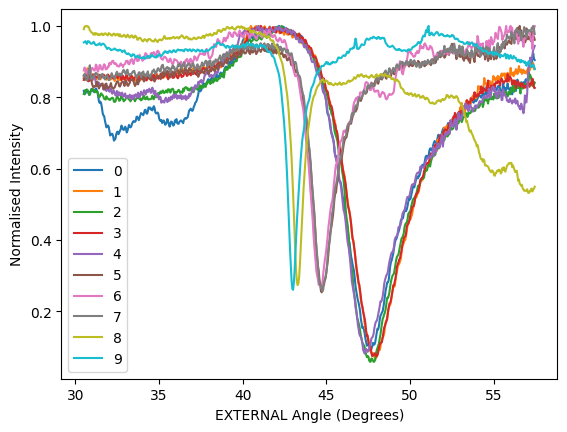

In [92]:
fileListGreen = glob("10nm/green/*.txt") + glob("13nm/green/*.txt") + glob("15nm/green/*.txt")

i=0
for file in [str(el) for el in np.sort(fileListGreen)]:
    PlotFile(file, errors=False, label=i)
    i+=1

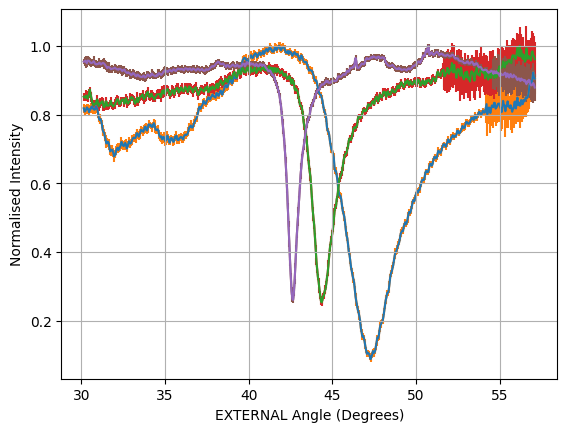

In [77]:
PlotFile("10nm/green/green01.txt", offset=30.15)
PlotFile("13nm/green/green01.txt", offset=30.15)
PlotFile("15nm/green/green02.txt", offset=30.15)

## Blue -> 405 nm

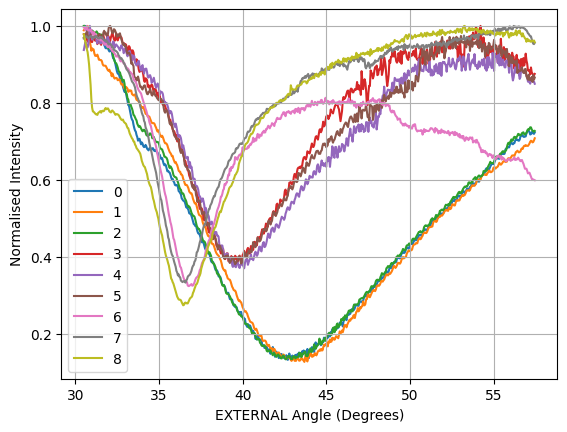

In [93]:
fileListBlue = glob("10nm/blue/*.txt") + glob("13nm/blue/*.txt") + glob("15nm/blue/*.txt")

i=0
for file in [str(el) for el in np.sort(fileListBlue)]:
    PlotFile(file, errors=False, label=i)
    i+=1

# Period of Oscillations

In [14]:
# Sawtooth wave function

from scipy import signal
from scipy.optimize import curve_fit
from scipy.odr import *

In [15]:
def Sin(t, amplitude, periodFactor, phase, height):
    return amplitude * np.sin(periodFactor *t + phase) + height

In [16]:
def FindPeriod(filePath, fitFunction, guessPars, showPlot=False, plotRange=[30.5,37], title=""):
    data = PlotFile(filePath, errors=False, showPlot=False, returnData=True)
    
    if data[:,0][0] == 43.955:
        data = np.flipud(data)
    data = np.delete(data, [np.arange(150,300,1)], 0)

    pars, cov = curve_fit(fitFunction, data[:,0], data[:,1], guessPars)

    t = np.linspace(plotRange[0], plotRange[1], 1000)
    
    period = 2* np.pi / pars[1]

    if showPlot:
        plt.scatter(data[:,0], data[:,1], label="Data", color="indianred", zorder=1)
        plt.plot(t, Sin(t, pars[0], pars[1], pars[2], pars[3]), label=f"Period of Oscillations: {period:0.2f}", color="cornflowerblue", zorder=0)
        plt.title(title)
        #plt.hlines(pars[3], plotRange[0], plotRange[0]+period, color = "orange", label=f"Period {period:0.2f}$^\circ$")
        plt.legend()
        plt.grid()

    uPeriod = np.sqrt(cov[1][1])

    return [period, uPeriod]

[0.6901732922850106, 1.2384517235201447, 1.7589334464656372, 3.12770424216502, 4.293773651217265, 6.115673636996935]
[0.027316929412567702, 0.02215232417917558, 0.02090828321249266, 0.01944736113510698, 0.01605945950755508, 0.023843644947239433]


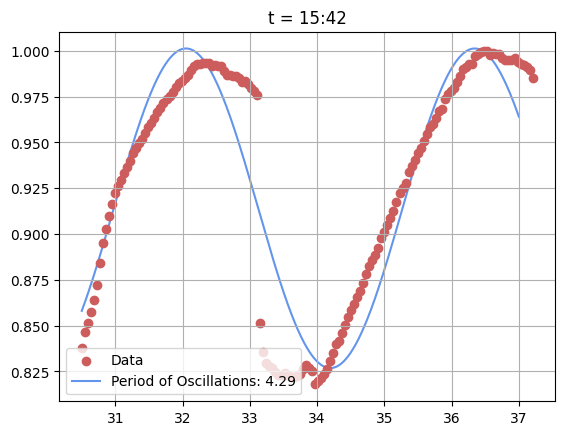

In [17]:
periods = list()

timeFiles = glob("Time/dep*.txt")
timeFiles = [str(el) for el in np.sort(timeFiles)]

p0 = FindPeriod(timeFiles[0], Sin, [0.1, 10, 0, 0.9], showPlot=False, title="t = 15:26")
p1 = FindPeriod(timeFiles[1], Sin, [0.1, 5, -1, 0.9], showPlot=False, title="t = 15:30")
p2 = FindPeriod(timeFiles[2], Sin, [0.1, 4, -1, 0.9], showPlot=False, title="t = 15:34")
p3 = FindPeriod(timeFiles[3], Sin, [0.1, 3, -1, 0.9], showPlot=False, title="t = 15:38")
p4 = FindPeriod(timeFiles[4], Sin, [0.1, 2, -1, 0.9], showPlot=True, title="t = 15:42")
p5 = FindPeriod(timeFiles[5], Sin, [0.1, 1/8, -1, 0.9], showPlot=False, title="t = 15:46")
periods = [p0[0], p1[0], p2[0], p3[0], p4[0], p5[0]]
uncertainties = [p0[1], p1[1], p2[1], p3[1], p4[1], p5[1]]
print(periods)
print(uncertainties)

[0.0099833  0.02945659 0.61382912]


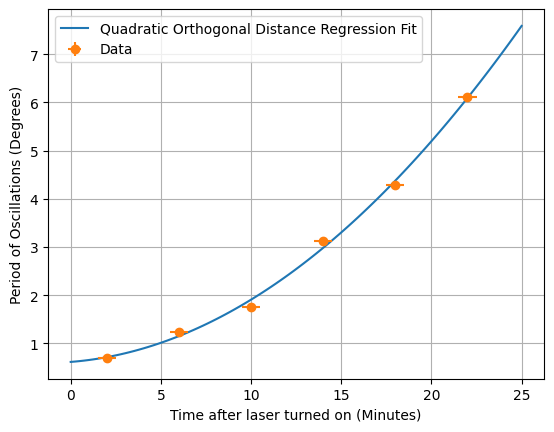

In [18]:
times = [2, 6, 10, 14, 18, 22]
uTime = 0.5 # minutes

def QuadFunc(p, x):
    A, B, C = p
    return A*x**2 + B*x + C

quadModel = Model(QuadFunc)

data = RealData(times, periods)

odr = ODR(data, quadModel, beta0=[1, 1, 1])

out = odr.run()
print(out.beta)
t = np.linspace(0, 25, 100)

plt.plot(t, QuadFunc(out.beta, t), label="Quadratic Orthogonal Distance Regression Fit")

plt.errorbar(times, periods, xerr=uTime, yerr=uncertainties, fmt="o", label="Data")
plt.xlabel("Time after laser turned on (Minutes)")
plt.ylabel("Period of Oscillations (Degrees)")
plt.grid()
plt.legend()

<ErrorbarContainer object of 3 artists>

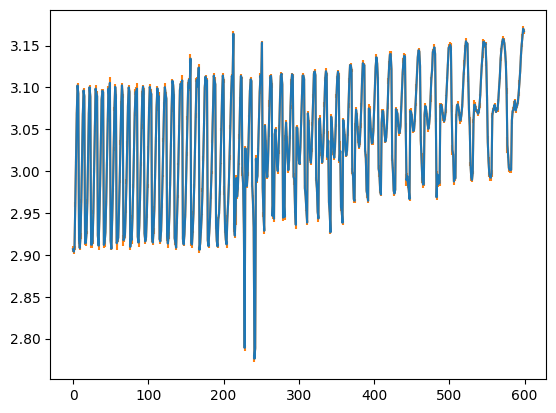

In [19]:
stilldata01 = LoadFile("13nm/still/still01.txt")

plt.plot(stilldata01[:,0], stilldata01[:,1], zorder=1)
plt.errorbar(stilldata01[:,0], stilldata01[:,1], yerr=stilldata01[:,2], fmt="", zorder=0)

<ErrorbarContainer object of 3 artists>

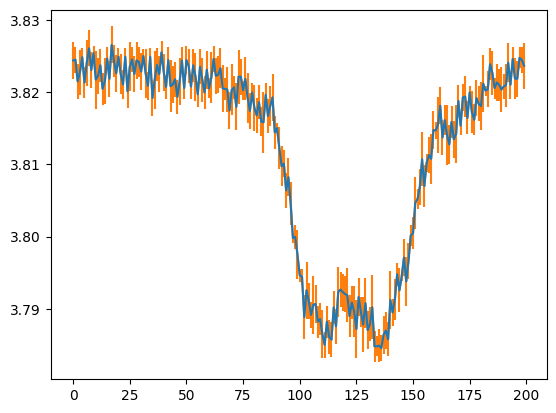

In [20]:
stilldata02 = LoadFile("13nm/still/still02.txt")

plt.plot(stilldata02[:,0], stilldata02[:,1], zorder=1)
plt.errorbar(stilldata02[:,0], stilldata02[:,1], yerr=stilldata02[:,2], fmt="", zorder=0)